# Crach course on Nilearn and MVPA (Multi-Variate Pattern Analysis)
* [Nilearn](https://nilearn.github.io) is a Python library for fast and easy statistical learning on NeuroImaging data.
It leverages the scikit-learn Python toolbox for multivariate statistics with applications such as predictive modelling, classification, decoding, or connectivity analysis.

* An open-source project, it started at the [Parietal Team @ INRIA / CEA Paris](https://team.inria.fr/parietal/), and is now part of a rich eco-system of Python tools for neuroimaging (including nipy, nipype, etc.).

* The code is hosted on [github](https://github.com/nilearn/nilearn), and we welcome new users and contributors.

Nilearn public dataset fetchers
===============================
Nilearn has plug-and-play functions to fetch a wide variety of popular datasets over the the web.

In [13]:
from nilearn import datasets

localizer_dataset = datasets.fetch_localizer_contrasts(
    ["left vs right button press"],
    n_subjects=2,
    get_tmaps=True)

In [15]:
type(localizer_dataset)

sklearn.datasets.base.Bunch

In [16]:
localizer_dataset.keys()

['cmaps', 'anats', 'description', 'ext_vars', 'tmaps', 'masks']

In [17]:
localizer_dataset.tmaps

['/home/elvis/nilearn_data/brainomics_localizer/brainomics_data/S01/t_map_left_auditory_&_visual_click_vs_right_auditory&visual_click.nii.gz',
 '/home/elvis/nilearn_data/brainomics_localizer/brainomics_data/S02/t_map_left_auditory_&_visual_click_vs_right_auditory&visual_click.nii.gz']

Interlude: Nibabel, loading nifti files (.nii, .nii.gz, .img, etc) in Python
============================================================================

In [24]:
import nibabel
tmap = nibabel.load(localizer_dataset.tmaps[0])
print(tmap)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (53, 63, 46)
affine: 
[[  -3.    0.    0.   78.]
 [   0.    3.    0. -111.]
 [   0.    0.    3.  -51.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : 
extents         : 0
session_error   : 0
regular         : r
dim_info        : 0
dim             : [ 3 53 63 46  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  3.  3.  3.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : SPM{T_[103.0]} - contrast 21: Left Click - Right Click
aux_file        : 
qform_cod

In [25]:
print(tmap.get_affine())

[[  -3.    0.    0.   78.]
 [   0.    3.    0. -111.]
 [   0.    0.    3.  -51.]
 [   0.    0.    0.    1.]]


In [28]:
print(tmap.shape)
print(type(tmap.get_data()))

(53, 63, 46)
<type 'numpy.ndarray'>


Plotting glass brains
=====================

In [1]:
%matplotlib inline

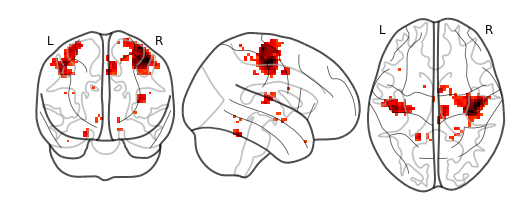

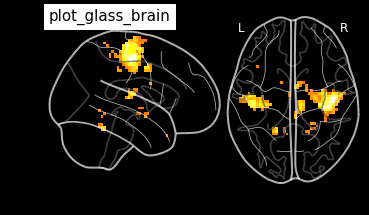

In [30]:
from nilearn import plotting

localizer_tmap_filename = localizer_dataset.tmaps[1]
plotting.plot_glass_brain(localizer_tmap_filename, threshold=3)

plotting.plot_glass_brain(
    localizer_tmap_filename, title='plot_glass_brain',
    black_bg=True, display_mode='xz', threshold=3)

plotting.show()

MVPA
====

Searchlight
-----------

Load Haxby dataset

In [4]:
import numpy as np
import nibabel
from nilearn import datasets
from nilearn.image import new_img_like

haxby_dataset = datasets.fetch_haxby_simple()

# print basic information on the dataset
print('Anatomical nifti image (3D) is located at: %s' % haxby_dataset.mask)
print('Functional nifti image (4D) is located at: %s' % haxby_dataset.func[0])

fmri_filename = haxby_dataset.func[0]
fmri_img = nibabel.load(fmri_filename)
y, session = np.loadtxt(haxby_dataset.session_target[0]).astype('int').T
conditions = np.recfromtxt(haxby_dataset.conditions_target[0])['f0']

Anatomical nifti image (3D) is located at: /home/elvis/nilearn_data/haxby2001_simple/pymvpa-exampledata/mask.nii.gz
Functional nifti image (4D) is located at: /home/elvis/nilearn_data/haxby2001_simple/pymvpa-exampledata/bold.nii.gz


Restrict analysis to face vs house contrast

In [5]:
from nilearn.image import index_img
condition_mask = np.logical_or(conditions == b'face', conditions == b'house')

fmri_img = index_img(fmri_img, condition_mask)
y, session = y[condition_mask], session[condition_mask]
conditions = conditions[condition_mask]

Prepare masks

* mask_img is the original mask
* process_mask_img is a subset of mask_img, it contains the voxels that should be processed (we only keep the slice z = 26 and the back of the brain to speed up computation)

In [6]:
mask_img = nibabel.load(haxby_dataset.mask)

# .astype() makes a copy.
process_mask = mask_img.get_data().astype(np.int)
picked_slice = 27
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0
process_mask_img = new_img_like(mask_img, process_mask)

Fit searchlight model on the data

In [7]:
# Make processing parallel
# /!\ As each thread will print its progress, n_jobs > 1 could mess up the
#     information output.
n_jobs = 1

# Define the cross-validation scheme used for validation.
# Here we use a KFold cross-validation on the session, which corresponds to
# splitting the samples in 4 folds and make 4 runs using each fold as a test
# set once and the others as learning sets
from sklearn.cross_validation import KFold
from sklearn.utils import check_random_state
random_state = check_random_state(7)  # seed the random-number generator to have reproducible results
cv = KFold(y.size, n_folds=4, random_state=random_state)

from nilearn.decoding import SearchLight
# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = SearchLight(
    mask_img, process_mask_img=process_mask_img,
    radius=5.6, n_jobs=n_jobs,
    verbose=1, cv=cv)
searchlight.fit(fmri_img, y)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   33.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.0s finished


SearchLight(cv=sklearn.cross_validation.KFold(n=216, n_folds=4, shuffle=False, random_state=<mtrand.RandomState object at 0xac6ffdcc>),
      estimator='svc',
      mask_img=<nibabel.nifti1.Nifti1Image object at 0xac36e6ec>, n_jobs=1,
      process_mask_img=<nibabel.nifti1.Nifti1Image object at 0xaca4876c>,
      radius=5.6, scoring=None, verbose=1)

We'll compare against a simple F-test

In [8]:
from nilearn.input_data import NiftiMasker

# For decoding, standardizing is often very important
nifti_masker = NiftiMasker(mask_img=mask_img, sessions=session,
                           standardize=True, memory='nilearn_cache',
                           memory_level=1)
fmri_masked = nifti_masker.fit_transform(fmri_img)

from sklearn.feature_selection import f_classif
f_values, p_values = f_classif(fmri_masked, y)
p_values = -np.log10(p_values)
p_values[p_values > 10] = 10
p_unmasked = nifti_masker.inverse_transform(p_values).get_data()

/home/elvis/.local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


Visualization

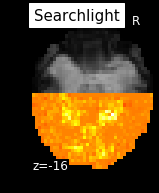

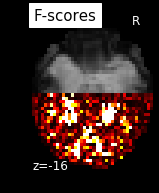

In [9]:
# Use the fmri mean image as a surrogate of anatomical data
from nilearn import image
mean_fmri = image.mean_img(fmri_img)

from nilearn.plotting import plot_stat_map, show
plot_stat_map(new_img_like(mean_fmri, searchlight.scores_), mean_fmri,
              title="Searchlight", display_mode="z", cut_coords=[-16],
              colorbar=False)

# F_score results
p_ma = np.ma.array(p_unmasked, mask=np.logical_not(process_mask))
plot_stat_map(new_img_like(mean_fmri, p_ma), mean_fmri,
              title="F-scores", display_mode="z",
              cut_coords=[-16], colorbar=False)

SpaceNet 
--------
This is a family of priors which simultaneously impose sparsity and structure on the maps of regressor coefficients. It includes GraphNet, TV-L1, Sparse-Variation, etc.

In [34]:
from nilearn.decoding import SpaceNetClassifier
sn = SpaceNetClassifier(cv=cv, verbose=1, mask=mask_img,
                        memory="nilearn_cache", memory_level=2  # cache results of intermediate computations
                       )
sn.fit(fmri_img, y)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished


Time Elapsed: 0.466201 seconds, 0 minutes.


SpaceNetClassifier(alphas=None,
          cv=sklearn.cross_validation.KFold(n=216, n_folds=4, shuffle=False, random_state=<mtrand.RandomState object at 0xac6ffdcc>),
          debias=False, eps=0.001, fit_intercept=True, high_pass=None,
          l1_ratios=0.5, loss='logistic', low_pass=None,
          mask=<nibabel.nifti1.Nifti1Image object at 0xac36e6ec>,
          max_iter=1000, memory=Memory(cachedir='nilearn_cache/joblib'),
          memory_level=2, n_alphas=10, n_jobs=1, penalty='graph-net',
          screening_percentile=20.0, standardize=True, t_r=None,
          target_affine=None, target_shape=None, tol=0.0001, verbose=1)

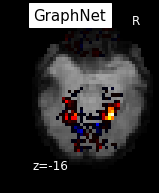

In [11]:
plot_stat_map(sn.coef_img_, mean_fmri,
              title="GraphNet", display_mode="z", cut_coords=[-16],
              colorbar=False)